In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


# Plotting all the dimensions of prosody encoding along the mel spectrogram

Mel plotting code: `plot_spectrogram_to_numpy` from `plotting_utils`

```python
def plot_spectrogram_to_numpy(spectrogram):
    spectrogram = spectrogram.astype(np.float32) # casting required when fp16_run.
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.tight_layout()

    fig.canvas.draw()
    data = save_figure_to_numpy(fig)
    plt.close()
    return data
```

In [2]:
from plotting_utils import plot_spectrogram_to_numpy, save_figure_to_numpy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from data_utils import TextMelLoader
from hparams import create_hparams

In [4]:
wav_path = '/data2/sungjaecho/data_tts/EmoV-DB/EmoV-DB/bea/angry/angry_0001.wav'

In [5]:
hparams = create_hparams()
valset = TextMelLoader(hparams, 'val')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
melspec = valset.get_mel(wav_path)
print(melspec.size())
print(melspec.type())

torch.Size([80, 316])
torch.FloatTensor


## 1. Run `plot_spectrogram_to_numpy`

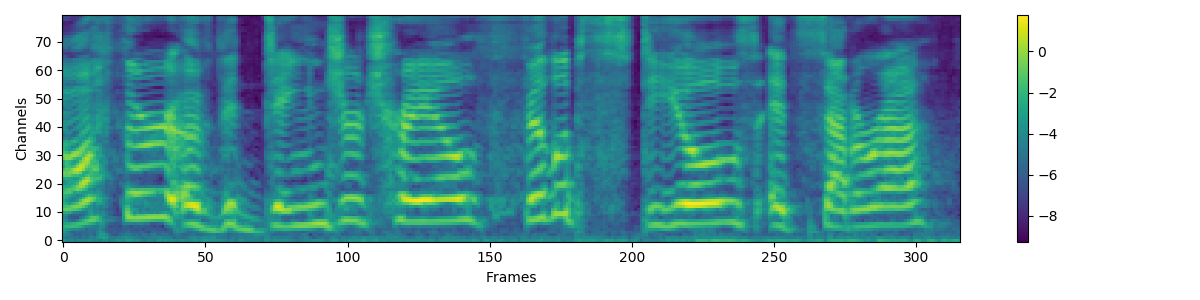

In [7]:
data = plot_spectrogram_to_numpy(melspec.numpy())
img = Image.fromarray(data, 'RGB')
img

## 2. Inspect `plot_spectrogram_to_numpy`

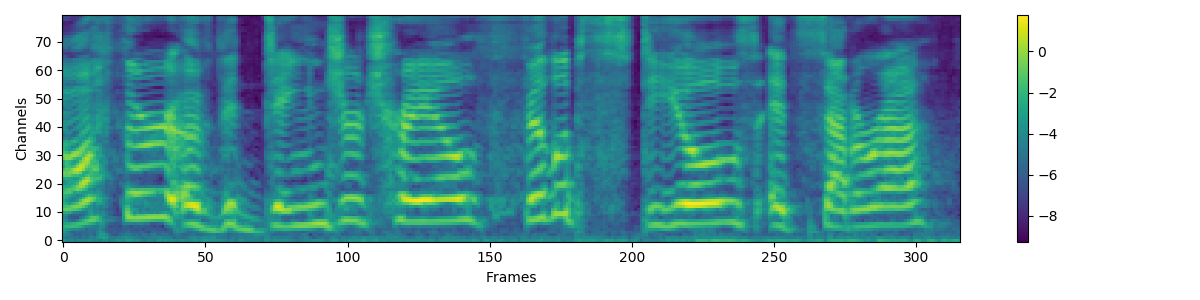

In [8]:
spectrogram = melspec.numpy()
spectrogram = spectrogram.astype(np.float32) # casting required when fp16_run.
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(spectrogram, aspect="auto", origin="lower",
               interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()

fig.canvas.draw()
data = save_figure_to_numpy(fig)
plt.close()
Image.fromarray(data, 'RGB')

## 3. Extend single plotting to double plotting.

In [9]:
x = np.arange(0, melspec.size(1))
prosody_dim = np.cos(x) + 1

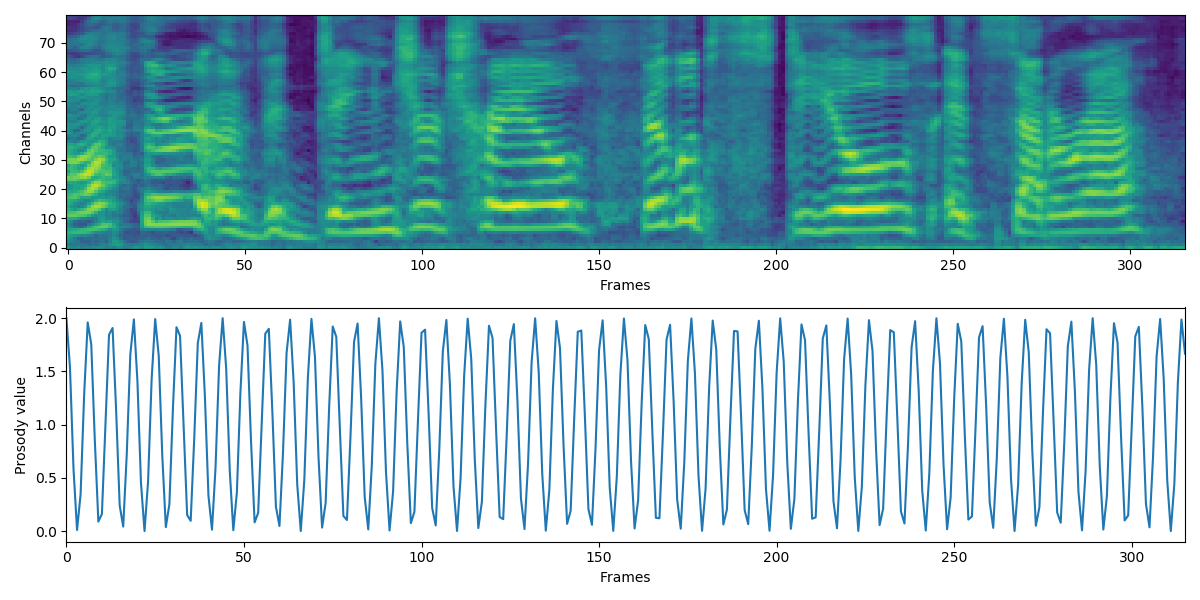

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

spectrogram = melspec.numpy()
spectrogram = spectrogram.astype(np.float32) # casting required when fp16_run.
ax[0].set_xlabel("Frames")
ax[0].set_ylabel("Channels")
im = ax[0].imshow(spectrogram, aspect="auto", origin="lower",
               interpolation='none')
#plt.colorbar(im, ax=ax[0])

prosody_dim = prosody_dim.astype(np.float32)
ax[1].set_xlim(x[0], x[-1])
ax[1].set_xlabel("Frames")
ax[1].set_ylabel("Prosody value")
ax[1].plot(x, prosody_dim)


plt.tight_layout()
fig.canvas.draw()
data = save_figure_to_numpy(fig)
plt.close()
Image.fromarray(data, 'RGB')

## 4. Extend double plotting to five plotting.

In [11]:
xx = np.arange(0, melspec.size(1))
prosody_dim = np.cos(xx) + 1
prosody = np.stack([prosody_dim] * 4)
prosody = prosody.T
print(prosody.shape)

(316, 4)


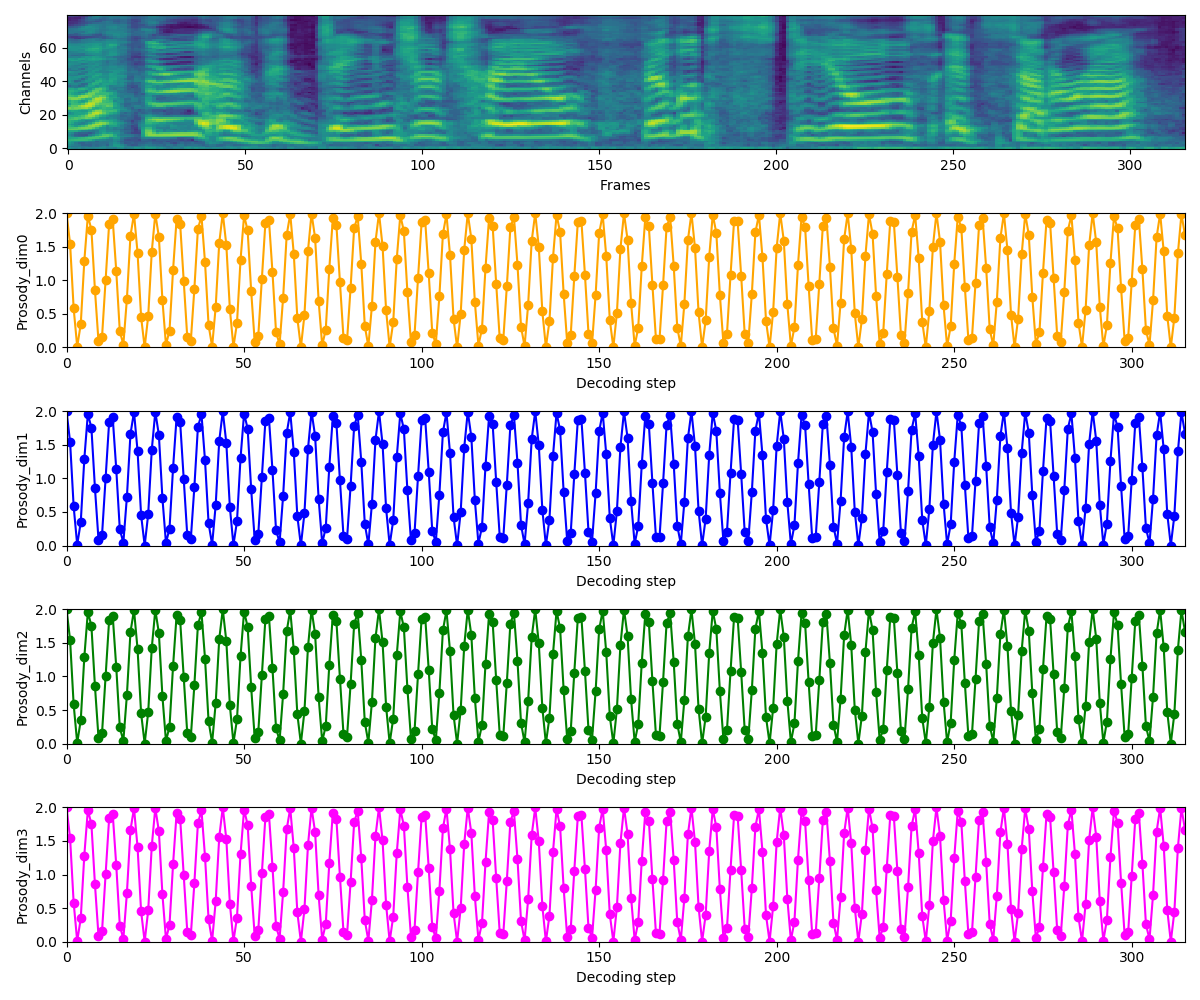

In [12]:
fig, ax = plt.subplots(prosody.shape[1]+1, 1, figsize=(12, 2*((prosody.shape[1]+1))))

spectrogram = melspec.numpy()
spectrogram = spectrogram.astype(np.float32) # casting required when fp16_run.
im = ax[0].imshow(spectrogram, aspect="auto", origin="lower",
               interpolation='none')
ax[0].set_xlabel("Frames")
ax[0].set_ylabel("Channels")
#plt.colorbar(im, ax=ax[0])

colors = ['orange', 'blue', 'green', 'magenta']
x = np.arange(prosody.shape[0])
for i_dim in range(prosody.shape[1]):
    prosody_dim = prosody[:,i_dim]
    prosody_dim = prosody_dim.astype(np.float32)
    ax[i_dim+1].plot(x, prosody_dim, 'o-', color=colors[i_dim % len(colors)])
    ax[i_dim+1].set_xlabel("Decoding step")
    ax[i_dim+1].set_ylabel("Prosody_dim{}".format(i_dim))
    ax[i_dim+1].set_xlim(x[0], x[-1])
    ax[i_dim+1].set_ylim(0, prosody_dim.max())

plt.tight_layout()
fig.canvas.draw()
data = save_figure_to_numpy(fig)
plt.close()
Image.fromarray(data, 'RGB')

## 5. Funcitonalize plotting

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from plotting_utils import save_figure_to_numpy

def plot_prosody_dims_to_numpy(spectrogram, prosody):
    '''
    PARAMS
    -----
    spectrogram: Spectrogram of speech.
    - type: numpy.ndarray.
    - shape: (frames, n_mel_channels)
    prosody: A pack of prosody encodings at speech spectrogram frames.
    - type: numpy.ndarry. 
    - shape: (frames, prosody_dim)
    
    RETURNS
    -----
    data: An image in the format of NumPy.
    - type: numpy.ndarray
    '''
    n_decoding_steps = prosody.shape[0]
    n_prosody_dims = prosody.shape[1]
   
    n_figures = 1 + n_prosody_dims
    fig, axes = plt.subplots(n_figures, 1, figsize=(12, 2*n_figures))
    
    # [1] First figure: Spectrogram
    spectrogram = spectrogram.astype(np.float32) # casting required when fp16_run.
    axes[0].set_xlabel("Frames")
    axes[0].set_ylabel("Channels")
    im = axes[0].imshow(spectrogram, aspect="auto", origin="lower",
               interpolation='none')
    
    # [2] The rest of figures: Prosody dimensions.
    colors = ['orange', 'blue', 'green', 'magenta']
    x = np.arange(n_decoding_steps)
    for i_dim in range(n_prosody_dims):
        prosody_dim = prosody[:,i_dim]
        prosody_dim = prosody_dim.astype(np.float32) # casting required when fp16_run.
        axes[i_dim+1].plot(x, prosody_dim, 'o-', color=colors[i_dim % len(colors)])
        axes[i_dim+1].set_xlabel("Decoding_step")
        axes[i_dim+1].set_ylabel("Prosody_dim{}".format(i_dim))
        axes[i_dim+1].set_xlim(x[0], x[-1])
        axes[i_dim+1].set_ylim(0, prosody_dim.max())
        
    # [3] Figure to an image
    plt.tight_layout()
    fig.canvas.draw()
    data = save_figure_to_numpy(fig)
    plt.close()
    
    return data

## 6. Test the function

In [3]:
from data_utils import TextMelLoader
from hparams import create_hparams
from PIL import Image

hparams = create_hparams()
valset = TextMelLoader(hparams, 'val')
wav_path = '/data2/sungjaecho/data_tts/EmoV-DB/EmoV-DB/bea/angry/angry_0001.wav'
melspec = valset.get_mel(wav_path)
spectrogram = melspec.numpy()
print(melspec.shape)
print(melspec.type())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

torch.Size([80, 316])
torch.FloatTensor


In [4]:
xx = np.arange(0, melspec.size(1))
prosody_dim = np.cos(xx) + 1
prosody = np.stack([prosody_dim] * 4)
prosody = prosody.T
print(prosody.shape)

(316, 4)


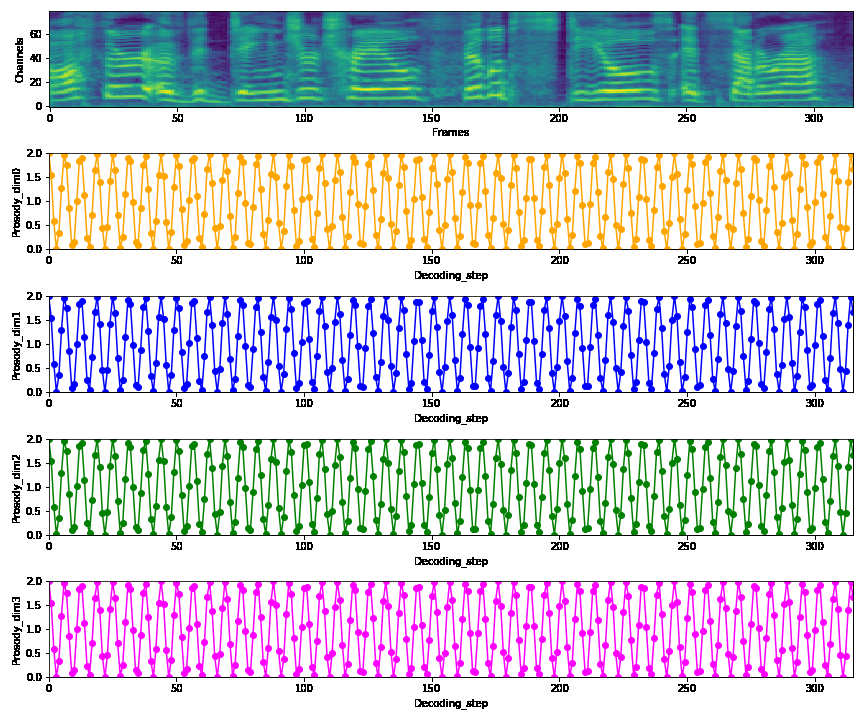

In [5]:
data = plot_prosody_dims_to_numpy(spectrogram, prosody)
Image.fromarray(data, 'RGB')